**Prediction of age of abalone using regression model**

**Introduction**

Abalone is a marine shell, which is a type of edible sea snail. It is rich in protein and omega-3 fatty acids. It has flattened ear shaped shell, well developed head with mouth, tentacles and eyes, and muscular foot. The shells are constructed from carbonate in the form of calcite, aragonite or both. As the shell formation begins from the larval stage and continues to the adult stage, rings are formed in it's outer layer. These growth rings are helpful for estimating age by counting concentric rings around the edge of shells.  However the rings in abalone are not completely reflectable to age, but they also depend on other environmental factors and feeding patterns.

The process of couting rings includes cutting the shell and checking rings in microscopic view but this process can be boring and time-consuming as some lines can be unclear and difficult to distinguish. As the economic value of abalone is positively correlated to it's age, it is important to determine it's age. So we are using machine learning techniques to predict the number of rings and then it's age from physical measurements.

**Importing dependencies and functions**

In [1]:
from google.colab import drive
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

**Mouting drive to access data files**

In [2]:
drive.mount('/content/drive', force_remount=True)
%ls /content/drive/MyDrive/abalone-age-prediction/

Mounted at /content/drive
abalone.data.csv


**Dataset**

Source:

The dataset is sourced from Machine Learning Repository of University of California (Arvine). This dataset comes from original study and it was donated on 11/30/1995.

*Warwick J Nash, Tracy L Sellers, Simon R Talbot, Andrew J Cawthorn and Wes B Ford (1994)
"The Population Biology of Abalone (Haliotis species) in Tasmania. I. Blacklip Abalone (H. rubra) from the North Coast and Islands of Bass Strait",
Sea Fisheries Division, Technical Report No. 48 (ISSN 1034-3288)*

About Dataset:

- Total number of observations: 4177

- Total features: 9

- Number of missing values: 0

**Data quality, cleaning and trasformation**

In [3]:
data_path = "/content/drive/MyDrive/abalone-age-prediction/abalone.data.csv"
df = pd.read_csv(data_path, names=["Sex", "Length", "Diameter", "Height", "Whole weight", "Shucked weight", "Viscera weight", "Shell weight", "Rings"])

First five observations

In [4]:
df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [5]:
df.shape

(4177, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


From above observation, it is seen that one feature is categorical and others are numerical

- Sex (M for Male, F for Female and I for Infant)

In [7]:
df.isnull().sum()

,0
Sex,0
Length,0
Diameter,0
Height,0
Whole weight,0
Shucked weight,0
Viscera weight,0
Shell weight,0
Rings,0


Verifying again if there are missing values or not.

- No missing values

In [8]:
df['Sex'].value_counts()

,count
Sex,
M,1528
I,1342
F,1307


Looking at the categorical distribution in terms of Sex, the dataset is evenly distributed.

In [9]:
df.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


Data description shows minimum value of height is 0.0 which is not practical.

Quering dataframe to see which observations have height 0.0

In [10]:
df[df['Height'] == 0.0]

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
1257,I,0.430,0.34,0.0,0.428,0.2065,0.0860,0.1150,8
3996,I,0.315,0.23,0.0,0.134,0.0575,0.0285,0.3505,6


Two abalones have height 0.0 and both are infant. To resolve this issue, we can replace them by average of height of infant abalones.

In [11]:
infantAverageHeight = df[df['Sex'] == 'I']['Height'].mean()

In [12]:
df.loc[df['Height'] == 0.0, 'Height'] = infantAverageHeight.round(6)

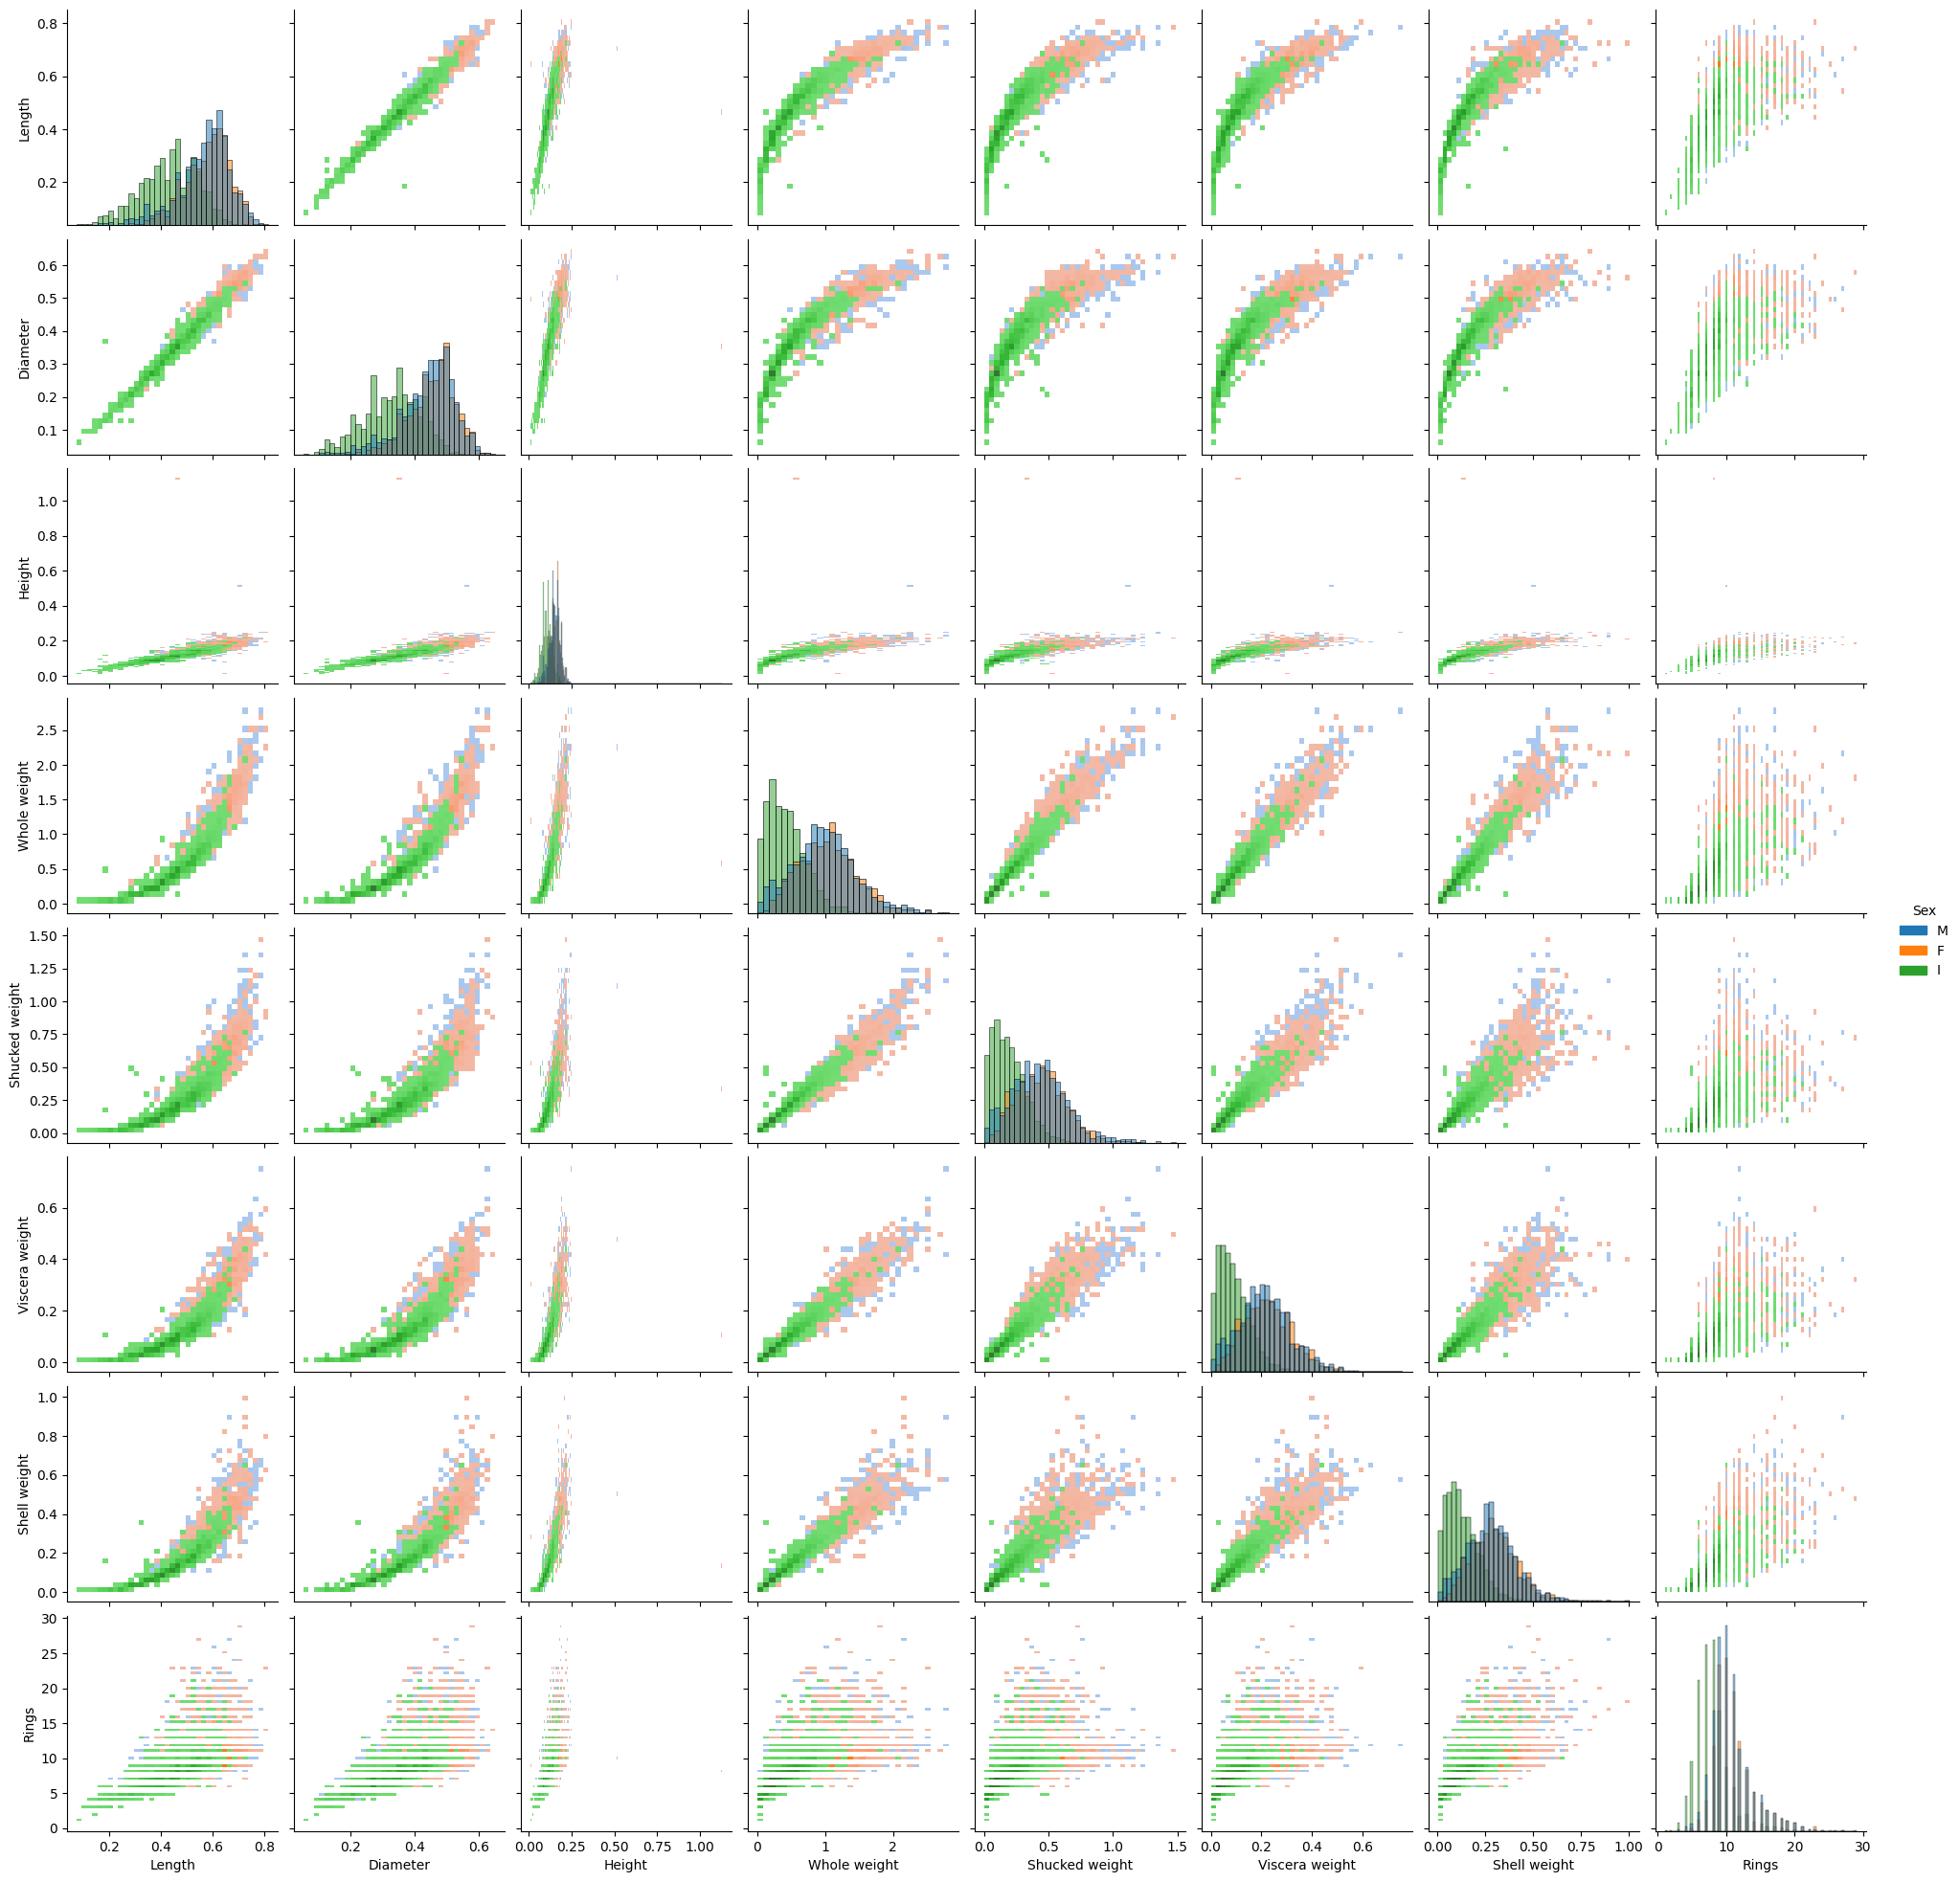

In [15]:
sns.pairplot(df, hue='Sex', kind='hist')

Looking at pairplot above and correlation heatmat below, it can be seen that `Length` and `Diameter` are extremely correlated (nearly 1). `Whole Weight` is highly correlated with other weight measurements: `Shucked weight`, `Viscera weight` and `Shell Weight`.

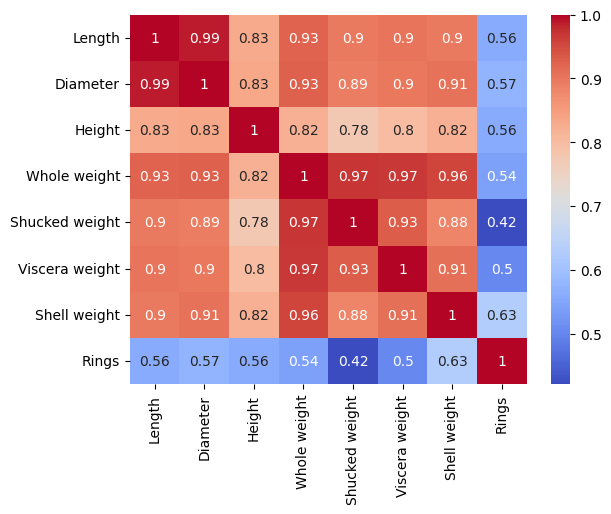

In [16]:
correlation_matrix = df.drop('Sex', axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

Visualising the distribution of each features with five number summary using `Box Plot`

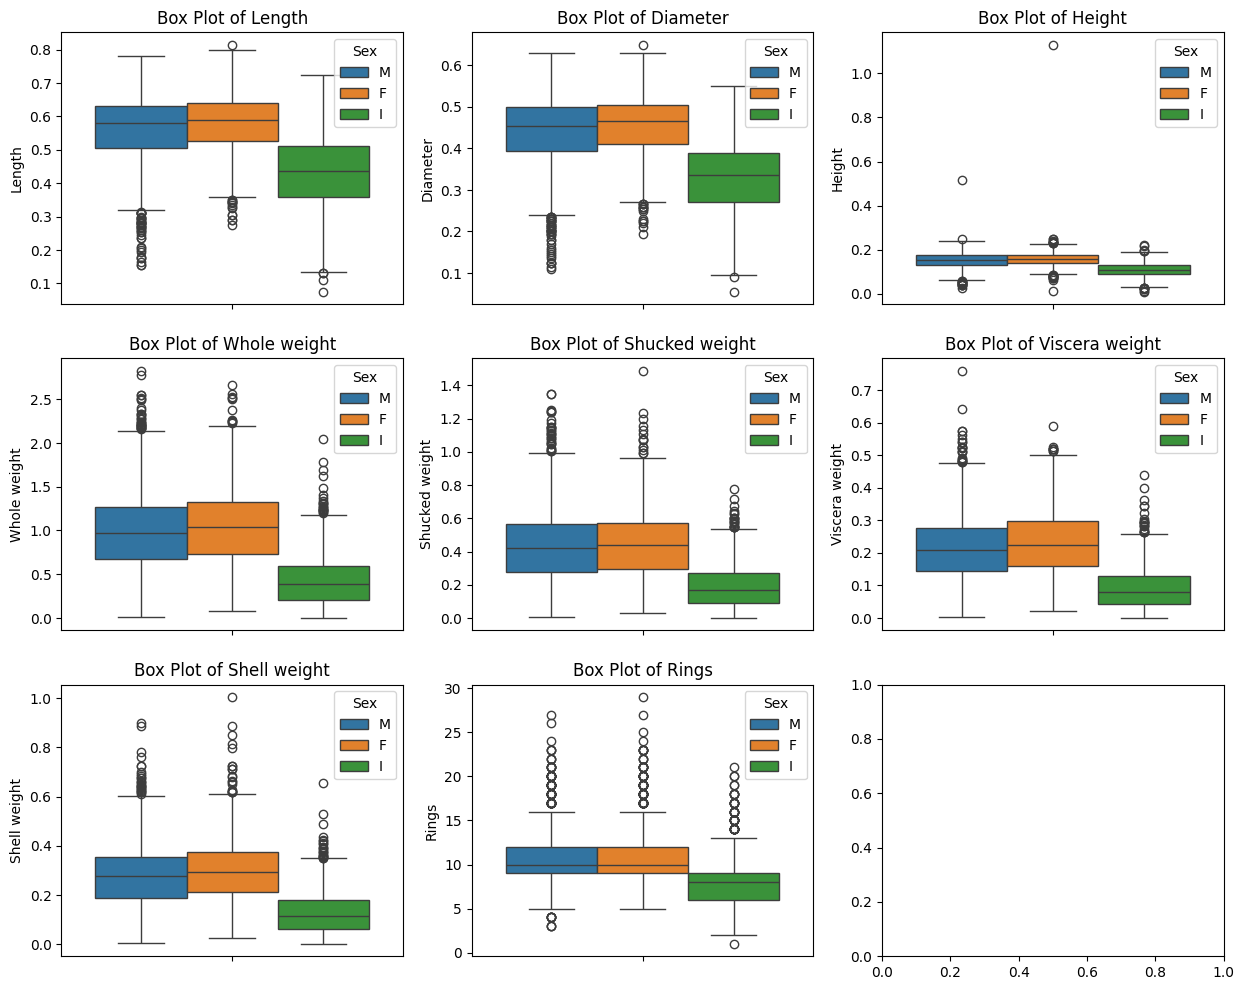

In [17]:
allFeatures = df.drop('Sex', axis=1).columns.tolist()
figRows = len(allFeatures) // 3 + (1 if len(allFeatures) % 3 != 0 else 0)
fig, axes = plt.subplots(figRows, 3, figsize=(15, 4 * figRows))

if figRows > 1:
    axes = axes.flatten()

for idx, feature in enumerate(allFeatures):
    row = idx // 3
    col = idx % 3

    if figRows == 1:
        ax = axes[col] if len(allFeatures) > 1 else axes
    else:
        ax = axes[idx]

    sns.boxplot(data=df, y=feature, hue='Sex', ax=ax)
    ax.set_title(f'Box Plot of {feature}')

Representing categorical feature `Sex` as numerical value using `LabelEncoder`

In [19]:
label_encoder = LabelEncoder()
df['Sex']= label_encoder.fit_transform(df['Sex'])

In [20]:
df['Sex'].unique()

array([2, 0, 1])

Separating the target variable `Rings` which is present in our dataset.

X as independent variables which are predicting features.

Y as dependent variable which is to be predicted.

In [21]:
Y = df['Rings']
X = df.drop('Rings', axis=1)

In [23]:
X.shape, Y.shape

((4177, 8), (4177,))

Using `Standard Scaler` to standardise the value of numerical features. This technique makes all values remain in an interval of [0,1] with a mean of 0 and a standard deviation of 1.

In [24]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

Splitting our complete dataset into train and test data in a ratio of 80:20 with random state of 42

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42)

Initialising five regression models with default parameters, followed by fitting them with training dataset and saving their predictions for both train and test data.

In [26]:
models = { 'LinearRegression': LinearRegression(),
          'XGBRegressor': XGBRegressor(),
          'Lasso': Lasso(),
           'RFRegressor': RandomForestRegressor(),
           'Ridge': Ridge()}

train_predictions = {}
test_predictions = {}

for key, value in models.items():
    models[key].fit(X_train, y_train)
    print(f'{key} : ')
    train_predictions[key] = models[key].predict(X_train)
    test_predictions[key] = models[key].predict(X_test)

LinearRegression : 
XGBRegressor : 
Lasso : 
RFRegressor : 
Ridge : 


Function to show performance metrics (`MAE`, `RMSE` and `R2`) of each model

In [54]:
def show_metrics(models, true_value, preds):
  col_labels = ['--']+list(preds.keys())
  row_labels = ['MAE', 'RMSE', 'R2']

  mae = {}
  rmse = {}
  r2 = {}

  for key, value in models.items():
    mae[key] = mean_absolute_error(true_value, preds[key])
    rmse[key] = root_mean_squared_error(true_value, preds[key])
    r2[key] = r2_score(true_value, preds[key])

  data = [
      col_labels,
      ['MAE']+list(mae.values()),
      ['RMSE']+list(rmse.values()),
      ['R2']+list(r2.values())
  ]

  metricsDf = pd.DataFrame(data)
  print(metricsDf)

In [55]:
show_metrics(models, y_train, train_predictions)

      0                 1             2         3            4         5
0    --  LinearRegression  XGBRegressor     Lasso  RFRegressor     Ridge
1   MAE          1.603619       0.53195  1.959518        0.569  1.603492
2  RMSE          2.207147      0.732788  2.691351     0.804363  2.207242
3    R2          0.526302      0.947785  0.295664     0.937087  0.526261


Looking at the performance of each models on `training data`, it can be seen that:

- `XGBRegressor` and `RFRegressor` have lower errors and higher R2 score.

Let's see how all of them perform in test (unseen) data.

In [42]:
show_metrics(models, y_test, test_predictions)

      0                 1             2         3            4         5
0    --  LinearRegression  XGBRegressor     Lasso  RFRegressor     Ridge
1   MAE           1.63012      1.633627  2.006868      1.56628  1.630833
2  RMSE          2.250042       2.35912  2.771748     2.226617   2.25005
3    R2          0.532324      0.485881  0.290306     0.542011  0.532321


So, `XGBRegressor` and `RFRegressor` could not perform well in test data. They are underfitted.

`Lasso` is seen weak on both set.

However, `LinearRegression` and `Ridge`, both generalized well with no sign of overfitting. Looking at R2 score, 0.53 is decent value but there is room to improve.

Let's hypertune `RFRegressor` with `GridSearchCV` with following parameters grid.

In [34]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]})

GridSearchCV found out optimal parameters from our defined parameter grid.
***Let's see how it performs on train and test data.***

In [44]:
rf_train_predictions = {
    'RF': train_predictions['RFRegressor'],
    'RF_tuned': grid_search.predict(X_train)
}
rf_test_predictions = {
    'RF': test_predictions['RFRegressor'],
    'RF_tuned': grid_search.predict(X_test)
}

In [46]:
rf_tuned_train_metrics = {}
rf_tuned_train_metrics['RMSE'] = root_mean_squared_error(y_train, rf_train_predictions['RF_tuned'])
rf_tuned_train_metrics['MAE'] = mean_absolute_error(y_train, rf_train_predictions['RF_tuned'])
rf_tuned_train_metrics['R2'] = r2_score(y_train, rf_train_predictions['RF_tuned'])

In [47]:
rf_tuned_test_metrics = {}
rf_tuned_test_metrics['RMSE'] = root_mean_squared_error(y_test, rf_test_predictions['RF_tuned'])
rf_tuned_test_metrics['MAE'] = mean_absolute_error(y_test, rf_test_predictions['RF_tuned'])
rf_tuned_test_metrics['R2'] = r2_score(y_test, rf_test_predictions['RF_tuned'])

In [56]:
show_metrics(rf_train_predictions, y_train, rf_train_predictions)

      0         1         2
0    --        RF  RF_tuned
1   MAE     0.569  0.992379
2  RMSE  0.804363   1.33667
3    R2  0.937087  0.826265


In [59]:
show_metrics(rf_test_predictions, y_test, rf_test_predictions)

      0         1         2
0    --        RF  RF_tuned
1   MAE   1.56628  1.558917
2  RMSE  2.226617  2.227163
3    R2  0.542011  0.541787


Looking at R2 scores, it decreases for train set after tuning but it doesn't perform better in test set. It shows that:

- RFRegressor couldn't generalize even with hypertuning.
- Requires more powerful models or feature engineering.